### 사전준비

### 환경설정


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/기계학습특론/8주차/assignment

/content/drive/MyDrive/기계학습특론/8주차/assignment


In [ ]:
!pip install ml-things

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00
  Created wheel for ml-things: filename=ml_things-0.0.1-py3-none-any.whl size=24394 sha256=fd3f6a85693eab40f0de6f90e07f5cd328eb918eb27770568619c9c68f392304
  Stored in directory: /root/.cache/pip/wheels/2a/b9/36/3725744c1d8ebec00cd847c9461b4352ce08de9d3f20b6bdcf
Successfully built ml-things


In [ ]:
# 한글 깨짐을 방지하는 코드
import matplotlib.pyplot as plt

# 가능한 font list 확인
import matplotlib.font_manager as fm
f = [f.name for f in fm.fontManager.ttflist]
print(f)

# 확인 이후
plt.rc('font', family='Malgun Gothic')

['DejaVu Serif', 'DejaVu Sans', 'cmr10', 'DejaVu Sans', 'STIXSizeFiveSym', 'DejaVu Sans Mono', 'cmsy10', 'STIXSizeTwoSym', 'STIXSizeTwoSym', 'STIXGeneral', 'STIXSizeThreeSym', 'STIXNonUnicode', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'STIXGeneral', 'cmmi10', 'STIXNonUnicode', 'DejaVu Sans Mono', 'cmss10', 'STIXGeneral', 'DejaVu Serif', 'STIXSizeOneSym', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXSizeFourSym', 'DejaVu Sans Display', 'cmtt10', 'DejaVu Serif Display', 'DejaVu Sans', 'cmex10', 'STIXGeneral', 'STIXSizeFourSym', 'DejaVu Serif', 'STIXNonUnicode', 'cmb10', 'DejaVu Serif', 'Liberation Sans', 'Liberation Mono', 'Liberation Mono', 'Liberation Serif', 'Liberation Sans Narrow', 'Liberation Sans', 'Liberation Sans', 'Liberation Sans', 'Liberation Serif', 'Liberation Mono', 'Liberation Sans Narrow', 'Liberation Sans Narrow', 'Humor Sans', 'Liberation Serif', 'Liberation Mono', 'Liberation Serif', 'Liberation Sans Narrow']


In [ ]:
import pandas as pd
import numpy as np
import re
import io
import os
from tqdm.notebook import tqdm
tqdm.pandas()
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score

# GPU 메모리 및 최대 시퀀스 길이에 따른 배치 수 설정이 필요
# 시퀀스 길이가 짧다면 32 이상의 배치 사이즈를 사용하는 것이 가능
batch_size = 32

data_path ='./라벨링데이터/TL_1.판결문'

# 분류 라벨
labels_ids = {'01_주장':0, '02_사실':1, '03_판단':2, '04_결론':3}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


In [ ]:
import json

f_path = './라벨링데이터/TL_1.판결문/01.민사/1981~2016/(전주)2012나186.json'

with open(f_path,'r',encoding='UTF8') as json_file:
    json_data = json.load(json_file)

for k in json_data:
    print(k)
    print(json_data[k])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


info
{'caseField': '1', 'detailField': '1', 'trailField': '2', 'caseNm': '손해배상(기)', 'courtNm': '광주고등법원', 'judmnAdjuDe': '2012. 12. 20.', 'caseNo': '(전주)2012나186', 'relateLaword': ['환경영향평가법 제22조', '환경영향평가법 시행령 제32조', '산지관리법 시행령 제32조', '구 행정심판법(2010. 1. 25. 법률 제9968호로 전부 개정되기 전의 것) 제37조', '행정심판법 제49조', '국가배상법 제2조 ', '하천법 제25조'], 'qotatPrcdnt': ['대법원 1998. 2. 27. 선고 96누13972 판결', '대법원 2001. 3. 23. 선고 99두5238 판결', '대법원 2001. 9. 14. 선고 99두3324 판결', '대법원 2003. 4.25. 선고 2002두3201 판결', '대법원 2009. 11. 26. 선고 2009두15586 판결', '대법원 2007. 6. 15. 선고 2005두9736 판결', '대법원 2000. 5. 12. 선고 99다70600 판결', '대법원 2004. 6. 11. 선고 2002다31018 판결 ']}
concerned
{'acusr': '2', 'dedat': '3'}
org
{'orgJdgmnCourtNm': '전주지방법원', 'orgJdgmnAdjuDe': '2011. 12. 9.', 'orgJdgmnCaseNo': '2011가합1452 '}
disposal
{'disposalform': '10', 'disposalcontent': ['제1심판결 중 피고 패소부분을 취소하고, 그 취소부분에 해당하는 원고의 청구를 기각한다.', '원고의 항소 및 당심에서 확장된 원고의 청구를 모두 기각한다.', '소송총비용은 원고가 부담한다.']}
mentionedItems
{'rqestObjet': ['피고는 원고에게 924,768,639원과 그 중 605,41

### 학습데이터 전처리

In [ ]:
import json
def is_json_key_present(json, key):
    try:
        buf = json[key]
    except KeyError:
        return False
    return True

class JsonDataset(Dataset):


  def __init__(self, path):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []


    for label in ['01.민사', '02.형사', '03.행정']:
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      for (root, directories, files) in os.walk(sentiment_path):
      # Go through each file and read its content.
        for file_name in tqdm(files, desc=f'{root} files'):
          file_path = os.path.join(root, file_name)
          with open(file_path, "r") as json_file:
            json_data  =  json.load(json_file)
            # print('json_data',json_data)
            if(is_json_key_present(json_data,"assrs") and is_json_key_present(json_data['assrs'],"acusrAssrs")) :
              for data in json_data['assrs']['acusrAssrs'] :
                self.texts.append(fix_text(data))
                self.labels.append('01_주장')

            if(is_json_key_present(json_data,"assrs") and is_json_key_present(json_data['assrs'],"dedatAssrs")) :
              for data in json_data['assrs']['dedatAssrs'] :
                self.texts.append(fix_text(data))
                self.labels.append('01_주장')

            if(is_json_key_present(json_data,"facts") and is_json_key_present(json_data['facts'],"bsisFacts")) :
              for data in json_data['facts']['bsisFacts'] :
                self.texts.append(fix_text(data))
                self.labels.append('02_사실')


            if(is_json_key_present(json_data,"dcss") and is_json_key_present(json_data['dcss'],"courtDcss")) :
              for data in json_data['dcss']['courtDcss'] :
                self.texts.append(fix_text(data))
                self.labels.append('03_판단')

            if(is_json_key_present(json_data,"close") and is_json_key_present(json_data['close'],"cnclsns")) :
              for data in json_data['close']['cnclsns'] :

                self.texts.append(fix_text(data))
                self.labels.append('04_결론')
    # Number of exmaples.
    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 모델 초기화

## 학습데이터 LOAD


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# JSON Data
dataset = JsonDataset(path=data_path)
df = pd.DataFrame.from_records(dataset)
df.groupby('label').size()

df = df.sample(frac=0.05, random_state=123)

df1 = df[df['label'].str.startswith('01')]
df2 = df[df['label'].str.startswith('02')]
df3 = df[df['label'].str.startswith('03')]
df4 = df[df['label'].str.startswith('04')]

# 전체 데이터에서 train, test 분리 (9 : 1)
df1_train, df1_test = train_test_split(df1, test_size=0.1, random_state=123)
df2_train, df2_test = train_test_split(df2, test_size=0.1, random_state=123)
df3_train, df3_test = train_test_split(df3, test_size=0.1, random_state=123)
df4_train, df4_test = train_test_split(df4, test_size=0.1, random_state=123)

df_train = pd.concat([df1_train,df2_train,df3_train,df4_train])
df_test = pd.concat([df1_test,df2_test,df3_test,df4_test])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#전체데이터 확인
df.groupby('label').size()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


label
01_주장    1763
02_사실    3266
03_판단    5901
04_결론    1110
dtype: int64

In [ ]:
!pip install --upgrade pip
!pip install JPype1-0.5.7-cp27-none-win_amd64.whl
!pip install konlpy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: JPype1-0.5.7-cp27-none-win_amd64.whl is not a supported wheel on this platform.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 34.8 MB/s eta 0:00:00


In [ ]:
# 한국어 형태소 분석기 Okt를 사용하기 위해 import
from konlpy.tag import Okt
# Okt의 객체 생성
okt = Okt()

# 한국어에서 의미가 거의 없는 단어들을 불용어 처리하기 위해 집합을 만듦
stop_words = set(['은', '는', '이', '가', '아', '하', '들', '것', '의', '있', '되', '수', '보', '주', '등', '한', '에'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 전처리 함수
def preprocessing(okt, review):
  # 한글이 아닌 단어는 지우고 " "으로 대체
  review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]", " ", review)
  # 형태소 분석을 하며 stemming 기법을 사용
  token_li = okt.morphs(review_text, stem=True)
  # 이전 stop_words에 포함되지 않는 단어만 clean_review에 들어갈 수 있게 함
  clean_review = [token for token in token_li if not token in stop_words]
  # 단어들을 ' '기준으로 이어 붙혀서 하나의 string 타입의 변수를 생성함
  clean_review = ' '.join(clean_review)

  # 전처리 완료된 문장을 return
  return clean_review.strip()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# preprocessing 함수를 적용
df_train["prepro_data"] = df_train["text"].progress_apply(lambda x: preprocessing(okt, x))
df_test["prepro_data"] = df_test["text"].progress_apply(lambda x: preprocessing(okt, x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10834 [00:00<?, ?it/s]

  0%|          | 0/1206 [00:00<?, ?it/s]

In [ ]:
# 전처리 과정에서 모든 문장이 삭제될 가능성이 있으므로, 해당 데이터 제거

print("공백 제거 전 훈련 데이터 개수: ", len(df_train))
train_not_empty_value = df_train["prepro_data"] != ""
df_train = df_train[train_not_empty_value]
print("공백 제거 후 훈련 데이터 개수: ", len(df_train))

print("공백 제거 전 태스트 데이터 개수: ", len(df_test))
test_not_empty_value = df_test["prepro_data"] != ""
df_test = df_test[test_not_empty_value]
print("공백 제거 후 테스트 데이터 개수: ", len(df_test))

공백 제거 전 훈련 데이터 개수:  10834
공백 제거 후 훈련 데이터 개수:  10831
공백 제거 전 태스트 데이터 개수:  1206
공백 제거 후 테스트 데이터 개수:  1206


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 순서 변경
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

# 훈련 데이터
x_train = df_train["prepro_data"].copy()
y_train = df_train["label"].copy()

# 테스트 데이터
x_test = df_test["prepro_data"].copy()
y_test = df_test["label"].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# tfidf embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer를 초기화하여 사용할 수 있다.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# 훈련 데이터에 대해 fit_transform을 수행하여 TF-IDF 행렬을 생성한다.
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# 테스트 데이터에 대해 transform을 수행하여 TF-IDF 행렬을 생성한다.
x_test_tfidf = tfidf_vectorizer.transform(x_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# modeling
from lightgbm import LGBMClassifier

# LightGBM 분류기를 초기화한다.
lgb_classifier = LGBMClassifier()

# 사용하고자 하는 파라미터 조합을 설정한다.
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127]
}

# GridSearchCV를 사용하여 5-fold cross validation을 수행하며 모델을 학습시킨다.
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(lgb_classifier, param_grid, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
grid_search.fit(x_train_tfidf, y_train)

# 최적의 파라미터를 출력한다.
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59773
[LightGBM] [Info] Number of data points in the train set: 10831, number of used features: 1696
[LightGBM] [Info] Start training from score -1.921828
[LightGBM] [Info] Start training from score -1.305024
[LightGBM] [Info] Start training from score -0.712821
[LightGBM] [Info] Start training from score -2.383413
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Normalized confusion matrix


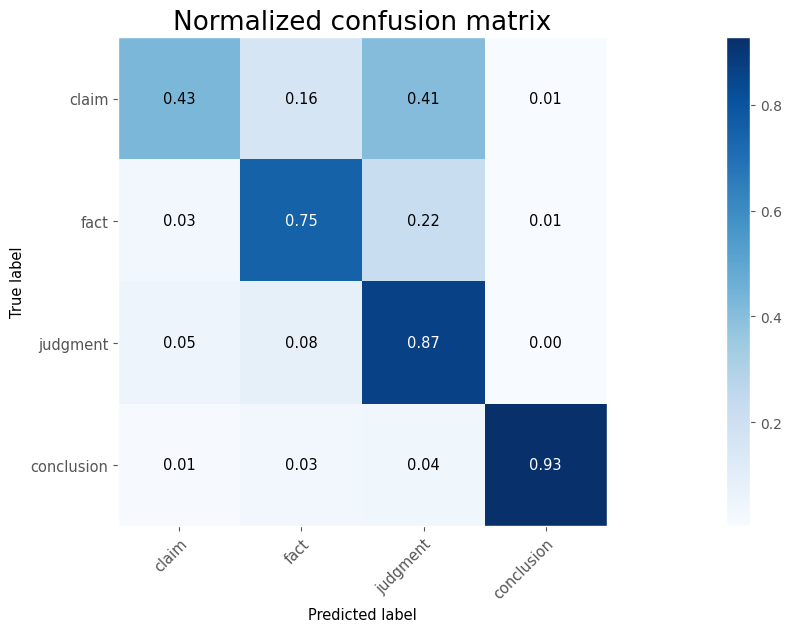

array([[0.42937853, 0.15819209, 0.40677966, 0.00564972],
       [0.02752294, 0.74923547, 0.21712538, 0.00611621],
       [0.04906937, 0.08121827, 0.86632826, 0.00338409],
       [0.00900901, 0.02702703, 0.03603604, 0.92792793]])

In [ ]:
# confusion matric 출력
from sklearn.metrics import confusion_matrix

from ml_things import plot_dict, plot_confusion_matrix
# 테스트 데이터에 대해 모델을 적용한다.
y_pred = grid_search.predict(x_test_tfidf)

# confusion matrix를 계산한다.
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)
# confusion matrix를 시각화한다.

plot_confusion_matrix(y_true=y_test,y_pred=y_pred,normalize=True,classes=['claim', 'fact', 'judgment', 'conclusion'])

In [ ]:
# 결과 리포트 출력
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

       01_주장       0.66      0.43      0.52       177
       02_사실       0.76      0.75      0.75       327
       03_판단       0.78      0.87      0.82       591
       04_결론       0.95      0.93      0.94       111

    accuracy                           0.78      1206
   macro avg       0.79      0.74      0.76      1206
weighted avg       0.77      0.78      0.77      1206



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
